In [ ]:
!pip install sodapy
!pip install feather-format
!pip install geopandas


In [5]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import collections
import re
from time import time
import math
import feather
from collections import defaultdict
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime

In [2]:
# Load SF Police Data
df = feather.read_dataframe('data/sf_incidents.feather')
print(df.shape)
df.head()

(701932, 9)


,incident_category,incident_date,incident_description,incident_dow,incident_number,incident_time,latitude,longitude,police_district
0,Homicide,2018-08-20,"Homicide, W/ Other Weapon",Monday,180624631,07:45,37.78610103879033,-122.41808809883916,Northern
1,Assault,2018-08-11,"Assault, Aggravated, W/ Other Weapon",Saturday,180602295,19:10,37.75683373380551,-122.40669900268833,Mission
2,Other Miscellaneous,2018-08-14,"Resisting, Delaying, or Obstructing Peace Off...",Tuesday,189002400,14:15,37.770555975146884,-122.39115601762397,Southern
3,Larceny Theft,2018-08-14,"Theft, Bicycle, >$950",Tuesday,180609984,15:07,37.766691459464916,-122.3926618696727,Southern
4,Other Miscellaneous,2018-08-14,"Burglary Tools, Possession Of",Tuesday,180609984,15:07,37.766691459464916,-122.3926618696727,Southern


In [3]:
df.dtypes

incident_category               object
incident_date           datetime64[ns]
incident_description            object
incident_dow                    object
incident_number                 object
incident_time                   object
latitude                        object
longitude                       object
police_district                 object
dtype: object

In [4]:
# dtype convert
int_cols = ["incident_number"]
for i_col in int_cols:
    df[i_col] = df[i_col].astype(int)
    
float_cols = ["latitude", "longitude"]
for f_col in float_cols:
    df[f_col] = df[f_col].astype(float)

In [27]:
census_blocks = gpd.read_file('data/census2010_ sf_blocks.geojson')
census_blocks.shape

(7386, 15)

In [6]:
# Load SF Census Track Data
census_tracks = gpd.read_file('data/census2010_ sf_tracks.geojson')
census_tracks = census_tracks[['geometry', 'namelsad10']]  # Keep only census track name / geometrydf

# Load SF Census Block Data
census_blocks = gpd.read_file('data/census2010_ sf_blocks.geojson')
census_blocks = census_blocks[['geometry', 'name10']]  # Keep only census track name / geometrydf

In [7]:
print(df.describe())
print(df.head())

       incident_number       latitude      longitude
count     7.019320e+05  691557.000000  691557.000000
mean      1.688268e+08     -80.101184      -4.553286
std       1.288314e+07      70.630061      70.629459
min       1.131000e+06    -122.513642    -122.511295
25%       1.601727e+08    -122.425087    -122.391434
50%       1.703679e+08    -122.409337      37.763091
75%       1.802612e+08      37.722225      37.782319
max       9.910090e+08      37.829991      37.819975
     incident_category incident_date  \
0             Homicide    2018-08-20   
1              Assault    2018-08-11   
2  Other Miscellaneous    2018-08-14   
3        Larceny Theft    2018-08-14   
4  Other Miscellaneous    2018-08-14   

                                incident_description incident_dow  \
0                          Homicide, W/ Other Weapon       Monday   
1               Assault, Aggravated, W/ Other Weapon     Saturday   
2  Resisting, Delaying, or Obstructing  Peace Off...      Tuesday   
3     

In [8]:
def epsg_converter(geodf):
    """
    return geodataframe with crs
    """
    crs = {'init': 'epsg:4326'}
    geodf = geodf.to_crs(crs)
    
    return geodf

In [9]:
# set crs
geodfs = [census_tracks, census_blocks]

for geodf in geodfs:
    geodf = epsg_converter(geodf)

In [10]:
def df_2_geodf(df, crs):
    """
    return geodataframe
    """
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    geodf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return geodf

In [11]:
crs = {'init':'epsg:4326'}
df = df_2_geodf(df, crs)

In [12]:
census_tracks.head()

,geometry,namelsad10
0,"(POLYGON ((-122.446471 37.775802, -122.44478 3...",Census Tract 165
1,"(POLYGON ((-122.44034 37.77658, -122.439844 37...",Census Tract 164
2,"(POLYGON ((-122.429152 37.778007, -122.428909 ...",Census Tract 163
3,"(POLYGON ((-122.428909 37.778039, -122.429152 ...",Census Tract 161
4,"(POLYGON ((-122.420425 37.780583, -122.420336 ...",Census Tract 160


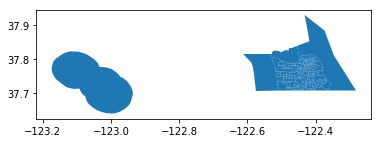

In [24]:
census_tracks.plot()

In [13]:
census_blocks.head()

,geometry,name10
0,"(POLYGON ((-122.440616 37.750902, -122.440459 ...",Block 2002
1,"(POLYGON ((-122.438397 37.750226, -122.43832 3...",Block 2000
2,"(POLYGON ((-122.435808 37.757623, -122.435642 ...",Block 3004
3,"(POLYGON ((-122.436527 37.75354, -122.436454 3...",Block 1003
4,"(POLYGON ((-122.432331 37.756227, -122.432254 ...",Block 4001


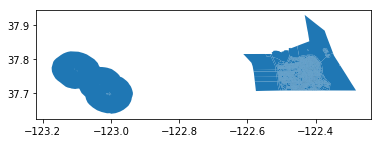

In [28]:
census_blocks.plot()

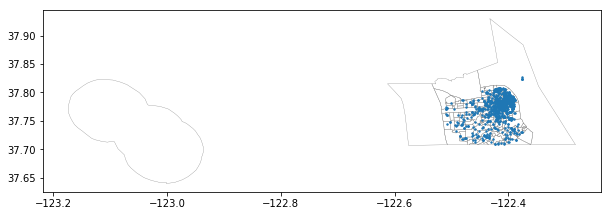

In [36]:
base = census_tracks.plot(color='none', edgecolor='gray', linewidth=.3, figsize=(10,5))
df[:1000].plot(ax=base, markersize=2)

In [19]:
# spatial join
df_wcensus = gpd.sjoin(df, census_tracks, how="inner", op='within')
df_wcensus = gpd.sjoin(df_wcensus, census_blocks, how="inner", op='within')

,incident_category,incident_date,incident_description,incident_dow,incident_number,incident_time,latitude,longitude,police_district,geometry,index_right,namelsad10
0,Homicide,2018-08-20,"Homicide, W/ Other Weapon",Monday,180624631,07:45,37.786101,-122.418088,Northern,POINT (-122.4180880988392 37.78610103879033),89.0,Census Tract 122.02
1,Assault,2018-08-11,"Assault, Aggravated, W/ Other Weapon",Saturday,180602295,19:10,37.756834,-122.406699,Mission,POINT (-122.4066990026883 37.75683373380551),128.0,Census Tract 228.02
2,Other Miscellaneous,2018-08-14,"Resisting, Delaying, or Obstructing Peace Off...",Tuesday,189002400,14:15,37.770556,-122.391156,Southern,POINT (-122.391156017624 37.77055597514688),98.0,Census Tract 607
3,Larceny Theft,2018-08-14,"Theft, Bicycle, >$950",Tuesday,180609984,15:07,37.766691,-122.392662,Southern,POINT (-122.3926618696727 37.76669145946492),98.0,Census Tract 607
4,Other Miscellaneous,2018-08-14,"Burglary Tools, Possession Of",Tuesday,180609984,15:07,37.766691,-122.392662,Southern,POINT (-122.3926618696727 37.76669145946492),98.0,Census Tract 607
5,Other Miscellaneous,2018-08-10,"Driving, No License Issued",Friday,180597511,05:20,37.765183,-122.417487,Mission,POINT (-122.4174865973267 37.76518313352035),190.0,Census Tract 177
6,Other Miscellaneous,2018-08-19,Trespassing,Sunday,180624885,23:20,37.756834,-122.406699,Mission,POINT (-122.4066990026883 37.75683373380551),128.0,Census Tract 228.02
7,Offences Against The Family And Children,2018-08-21,"EPO or Restraining Order Violation, DVU related",Tuesday,180628906,10:43,37.764260,-122.389852,Southern,POINT (-122.3898519611486 37.76426021440879),171.0,Census Tract 226
8,Non-Criminal,2018-08-15,Aided Case,Wednesday,180615301,16:40,37.753837,-122.418594,Mission,POINT (-122.4185939462998 37.75383658673179),182.0,Census Tract 209
9,Missing Person,2018-08-17,Found Person,Friday,180620065,23:17,37.747286,-122.459174,Park,POINT (-122.4591743767475 37.74728631866501),130.0,Census Tract 304


In [17]:
# Weather Data via NOAA request
weather = pd.read_csv('data/weather.csv')
weather = weather[['NAME',  'LATITUDE',  'LONGITUDE', 'DATE', 'PRCP', 'TAVG']]
print(weather.describe())
print(weather.head())

            LATITUDE      LONGITUDE           PRCP          TAVG
count  120530.000000  120530.000000  105010.000000  20127.000000
mean       37.804167    -122.286561       0.097325     58.090277
std         0.207808       0.221397       0.319468      9.046352
min        37.375400    -122.702200       0.000000     33.000000
25%        37.619700    -122.482500       0.000000     52.000000
50%        37.869800    -122.260500       0.000000     57.000000
75%        37.983300    -122.115000       0.000000     63.000000
max        38.210200    -121.865500       7.570000    109.000000
                      NAME  LATITUDE  LONGITUDE        DATE  PRCP  TAVG
0  BERKELEY 0.9 SSE, CA US   37.8552  -122.2892  2017-07-01   0.0   NaN
1  BERKELEY 0.9 SSE, CA US   37.8552  -122.2892  2017-07-02   0.0   NaN
2  BERKELEY 0.9 SSE, CA US   37.8552  -122.2892  2017-07-03   0.0   NaN
3  BERKELEY 0.9 SSE, CA US   37.8552  -122.2892  2017-07-04   0.0   NaN
4  BERKELEY 0.9 SSE, CA US   37.8552  -122.2892  2017-0

/usr/local/var/pyenv/versions/3.7.2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,21,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Merge Weather with data via Day 

In [174]:
df_wcensus.head()

,incident_category,incident_date,incident_description,incident_dow,incident_number,incident_time,latitude,longitude,police_district
0,Homicide,2018-08-20,"Homicide, W/ Other Weapon",Monday,180624631,07:45,37.78610103879033,-122.41808809883916,Northern
1,Assault,2018-08-11,"Assault, Aggravated, W/ Other Weapon",Saturday,180602295,19:10,37.75683373380551,-122.40669900268833,Mission
2,Other Miscellaneous,2018-08-14,"Resisting, Delaying, or Obstructing Peace Off...",Tuesday,189002400,14:15,37.770555975146884,-122.39115601762397,Southern
3,Larceny Theft,2018-08-14,"Theft, Bicycle, >$950",Tuesday,180609984,15:07,37.766691459464916,-122.3926618696727,Southern
4,Other Miscellaneous,2018-08-14,"Burglary Tools, Possession Of",Tuesday,180609984,15:07,37.766691459464916,-122.3926618696727,Southern


In [175]:
df_wcensus = df_wcensus.rename(columns={'incident_date': 'DATE'})
df_wcensus.head()

,incident_category,DATE,incident_description,incident_dow,incident_number,incident_time,latitude,longitude,police_district
0,Homicide,2018-08-20,"Homicide, W/ Other Weapon",Monday,180624631,07:45,37.78610103879033,-122.41808809883916,Northern
1,Assault,2018-08-11,"Assault, Aggravated, W/ Other Weapon",Saturday,180602295,19:10,37.75683373380551,-122.40669900268833,Mission
2,Other Miscellaneous,2018-08-14,"Resisting, Delaying, or Obstructing Peace Off...",Tuesday,189002400,14:15,37.770555975146884,-122.39115601762397,Southern
3,Larceny Theft,2018-08-14,"Theft, Bicycle, >$950",Tuesday,180609984,15:07,37.766691459464916,-122.3926618696727,Southern
4,Other Miscellaneous,2018-08-14,"Burglary Tools, Possession Of",Tuesday,180609984,15:07,37.766691459464916,-122.3926618696727,Southern


In [176]:
weather["DATE"] = pd.to_datetime(weather["DATE"])

In [177]:
weather_group.dtypes

DATE         datetime64[ns]
LATITUDE            float64
LONGITUDE           float64
PRCP                float64
TAVG                float64
dtype: object

In [178]:
weather_group = weather.groupby("DATE").mean().reset_index()

In [179]:
weather_group["DATE"] = pd.to_datetime(weather_group["DATE"])

In [180]:
df_weather = pd.merge(df_wcensus, weather_group, on='DATE', how ="inner")

In [181]:
print(df_weather.describe())
print(df_weather.head())

            LATITUDE      LONGITUDE           PRCP           TAVG
count  701932.000000  701932.000000  701932.000000  701932.000000
mean       37.803910    -122.285657       0.076154      57.332679
std         0.009819       0.014220       0.229723       8.029537
min        37.771889    -122.321686       0.000000      38.307692
25%        37.796987    -122.297120       0.000000      52.000000
50%        37.804020    -122.284410       0.000263      56.076923
75%        37.810732    -122.274040       0.012034      62.769231
max        37.839996    -122.250239       2.228182      92.307692
     incident_category       DATE  \
0             Homicide 2018-08-20   
1              Assault 2018-08-11   
2  Other Miscellaneous 2018-08-14   
3        Larceny Theft 2018-08-14   
4  Other Miscellaneous 2018-08-14   

                                incident_description incident_dow  \
0                          Homicide, W/ Other Weapon       Monday   
1               Assault, Aggravated, W/ Other

# Collapse BY Time Period

In [182]:
# I am not sure this code is correct in order to extract hour values from the columns "incident_time"
df_weather['hour'] = pd.to_datetime(df['incident_time'], format='%H:%M').dt.hour

In [185]:
df_weather.head()

,incident_category,DATE,incident_description,incident_dow,incident_number,incident_time,latitude,longitude,police_district,LATITUDE,LONGITUDE,PRCP,TAVG,hour
0,Homicide,2018-08-20,"Homicide, W/ Other Weapon",Monday,180624631,07:45,37.78610103879033,-122.41808809883916,Northern,37.804384,-122.267371,0.0,61.230769,7
1,Assault,2018-08-20,"Assault, Non-Aggravated",Monday,180625225,09:30,37.77264947305175,-122.41500165430014,Southern,37.804384,-122.267371,0.0,61.230769,19
2,Forgery And Counterfeiting,2018-08-20,"Checks, False, Making, Uttering or Possessing",Monday,180746257,00:00,37.80171452756283,-122.45660798316943,Central,37.804384,-122.267371,0.0,61.230769,14
3,Lost Property,2018-08-20,Lost Property,Monday,180747142,08:00,37.78202549388128,-122.4848742588828,Richmond,37.804384,-122.267371,0.0,61.230769,15
4,Lost Property,2018-08-20,Lost Property,Monday,186224459,08:00,37.786851714583754,-122.40126150328634,Southern,37.804384,-122.267371,0.0,61.230769,15


In [186]:
df_weather.dtypes

incident_category               object
DATE                    datetime64[ns]
incident_description            object
incident_dow                    object
incident_number                 object
incident_time                   object
latitude                        object
longitude                       object
police_district                 object
LATITUDE                       float64
LONGITUDE                      float64
PRCP                           float64
TAVG                           float64
hour                             int64
dtype: object

In [187]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [188]:
incident_type = df['incident_type'].value_counts()
print(incident_type)

LARCENY/THEFT                                 146464
OTHER OFFENSES                                 63493
Larceny Theft                                  60442
NON-CRIMINAL                                   59762
ASSAULT                                        44579
VANDALISM                                      28878
VEHICLE THEFT                                  21413
BURGLARY                                       19429
WARRANTS                                       19400
SUSPICIOUS OCC                                 18892
Other Miscellaneous                            15093
MISSING PERSON                                 14615
DRUG/NARCOTIC                                  13231
Non-Criminal                                   12135
Assault                                        11470
ROBBERY                                        11284
Malicious Mischief                             11180
FRAUD                                           8978
Burglary                                      

In [189]:
# numeric converter
df_weather['incident_number'] = df_weather['incident_number'].astype(int)
df_weather["incident_type"] = df_weather["incident_type"].map(
    {"violent":0,
     "property":1,
     "other":2}).astype(int)
df_weather["incident_dow"] = df_weather["incident_dow"].map({"Monday": 0, "Tuesday": 1,
  "Wednesday":2,"Thursday":3,"Friday":4, "Saturday":5,"Sunday":6}).astype(int)

In [190]:
df_weather.head()

,incident_category,DATE,incident_description,incident_dow,incident_number,incident_time,latitude,longitude,police_district,LATITUDE,LONGITUDE,PRCP,TAVG,hour
0,53,2018-08-20,"Homicide, W/ Other Weapon",0,180624631,07:45,37.78610103879033,-122.41808809883916,Northern,37.804384,-122.267371,0.0,61.230769,7
1,3,2018-08-20,"Assault, Non-Aggravated",0,180625225,09:30,37.77264947305175,-122.41500165430014,Southern,37.804384,-122.267371,0.0,61.230769,19
2,25,2018-08-20,"Checks, False, Making, Uttering or Possessing",0,180746257,00:00,37.80171452756283,-122.45660798316943,Central,37.804384,-122.267371,0.0,61.230769,14
3,15,2018-08-20,Lost Property,0,180747142,08:00,37.78202549388128,-122.4848742588828,Richmond,37.804384,-122.267371,0.0,61.230769,15
4,15,2018-08-20,Lost Property,0,186224459,08:00,37.786851714583754,-122.40126150328634,Southern,37.804384,-122.267371,0.0,61.230769,15


In [191]:
df_weather.isnull().sum()

incident_category       0
DATE                    0
incident_description    0
incident_dow            0
incident_number         0
incident_time           0
latitude                0
longitude               0
police_district         0
LATITUDE                0
LONGITUDE               0
PRCP                    0
TAVG                    0
hour                    0
dtype: int64

In [196]:
df_dummies = pd.get_dummies(df_weather, columns=['incident_type', 'incident_dow'])
df_dummies.head()

,DATE,incident_description,incident_number,incident_time,latitude,longitude,police_district,LATITUDE,LONGITUDE,PRCP,TAVG,hour,incident_category_0,incident_category_1,incident_category_2,incident_category_3,incident_category_4,incident_category_5,incident_category_6,incident_category_7,incident_category_8,incident_category_9,incident_category_10,incident_category_11,incident_category_12,incident_category_13,incident_category_14,incident_category_15,incident_category_16,incident_category_17,incident_category_18,incident_category_19,incident_category_20,incident_category_21,incident_category_22,incident_category_23,incident_category_24,incident_category_25,incident_category_26,incident_category_27,incident_category_28,incident_category_29,incident_category_30,incident_category_31,incident_category_32,incident_category_33,incident_category_34,incident_category_35,incident_category_36,incident_category_37,incident_category_38,incident_category_39,incident_category_40,incident_category_41,incident_category_42,incident_category_43,incident_category_44,incident_category_45,incident_category_46,incident_category_47,incident_category_48,incident_category_49,incident_category_50,incident_category_51,incident_category_52,incident_category_53,incident_category_54,incident_dow_0,incident_dow_1,incident_dow_2,incident_dow_3,incident_dow_4,incident_dow_5,incident_dow_6
0,2018-08-20,"Homicide, W/ Other Weapon",180624631,07:45,37.78610103879033,-122.41808809883916,Northern,37.804384,-122.267371,0.0,61.230769,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,2018-08-20,"Assault, Non-Aggravated",180625225,09:30,37.77264947305175,-122.41500165430014,Southern,37.804384,-122.267371,0.0,61.230769,19,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2018-08-20,"Checks, False, Making, Uttering or Possessing",180746257,00:00,37.80171452756283,-122.45660798316943,Central,37.804384,-122.267371,0.0,61.230769,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2018-08-20,Lost Property,180747142,08:00,37.78202549388128,-122.4848742588828,Richmond,37.804384,-122.267371,0.0,61.230769,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2018-08-20,Lost Property,186224459,08:00,37.786851714583754,-122.40126150328634,Southern,37.804384,-122.267371,0.0,61.230769,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [197]:
df_dummies = df_dummies.drop(columns = ['incident_time','LATITUDE','LONGITUDE'])

In [198]:
df_dummies.head()

,DATE,incident_number,latitude,longitude,PRCP,TAVG,hour,incident_category_0,incident_category_1,incident_category_2,incident_category_3,incident_category_4,incident_category_5,incident_category_6,incident_category_7,incident_category_8,incident_category_9,incident_category_10,incident_category_11,incident_category_12,incident_category_13,incident_category_14,incident_category_15,incident_category_16,incident_category_17,incident_category_18,incident_category_19,incident_category_20,incident_category_21,incident_category_22,incident_category_23,incident_category_24,incident_category_25,incident_category_26,incident_category_27,incident_category_28,incident_category_29,incident_category_30,incident_category_31,incident_category_32,incident_category_33,incident_category_34,incident_category_35,incident_category_36,incident_category_37,incident_category_38,incident_category_39,incident_category_40,incident_category_41,incident_category_42,incident_category_43,incident_category_44,incident_category_45,incident_category_46,incident_category_47,incident_category_48,incident_category_49,incident_category_50,incident_category_51,incident_category_52,incident_category_53,incident_category_54,incident_dow_0,incident_dow_1,incident_dow_2,incident_dow_3,incident_dow_4,incident_dow_5,incident_dow_6
0,2018-08-20,180624631,37.78610103879033,-122.41808809883916,0.0,61.230769,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,2018-08-20,180625225,37.77264947305175,-122.41500165430014,0.0,61.230769,19,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2018-08-20,180746257,37.80171452756283,-122.45660798316943,0.0,61.230769,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2018-08-20,180747142,37.78202549388128,-122.4848742588828,0.0,61.230769,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2018-08-20,186224459,37.786851714583754,-122.40126150328634,0.0,61.230769,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [200]:
df_new = pd.DataFrame()
df_group = df_dummies.groupby(["DATE", "hour"])
df_new = df_group.agg({ 'incident_number': 'nunique',
    'incident_type_0': lambda x: x.sum() / x.count(),
    'incident_type_1': lambda x: x.sum() / x.count(),
    'incident_type_1': lambda x: x.sum() / x.count(),
    'incident_dow_0': lambda x: x.sum() / x.count(),
    'incident_dow_1': lambda x: x.sum() / x.count(),
    'incident_dow_2': lambda x: x.sum() / x.count(),                       
    'incident_dow_3': lambda x: x.sum() / x.count(),
    'incident_dow_4': lambda x: x.sum() / x.count(),
    'incident_dow_5': lambda x: x.sum() / x.count(),
    'incident_dow_6': lambda x: x.sum() / x.count(),
    'PRCP': lambda x: x.mean(),
    'TAVG': lambda x: x.mean()}).reset_index()
df_new.describe()

,hour,incident_number,incident_category_0,incident_category_1,incident_category_2,incident_category_3,incident_category_4,incident_category_5,incident_category_6,incident_category_7,incident_category_8,incident_category_9,incident_category_10,incident_category_11,incident_category_12,incident_category_13,incident_category_14,incident_category_15,incident_category_16,incident_category_17,incident_category_18,incident_category_19,incident_category_20,incident_category_21,incident_category_22,incident_category_23,incident_category_24,incident_category_25,incident_category_26,incident_category_27,incident_category_28,incident_category_29,incident_category_30,incident_category_31,incident_category_32,incident_category_33,incident_category_34,incident_category_35,incident_category_36,incident_category_37,incident_category_38,incident_category_39,incident_category_40,incident_category_41,incident_category_42,incident_category_43,incident_category_44,incident_category_45,incident_category_46,incident_category_47,incident_category_48,incident_category_49,incident_category_50,incident_category_51,incident_category_52,incident_category_53,incident_category_54,incident_dow_0,incident_dow_1,incident_dow_2,incident_dow_3,incident_dow_4,incident_dow_5,incident_dow_6,PRCP,TAVG
count,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.00000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000,37485.000000
mean,11.518101,17.785594,0.301487,0.093453,0.102817,0.079044,0.043320,0.040420,0.039562,0.037481,0.031698,0.023602,0.027251,0.025455,0.022528,0.015274,0.020614,0.008365,0.009077,0.009517,0.007705,0.007519,0.005512,0.004730,0.004564,0.005717,0.003719,0.004089,0.003121,0.002427,0.003656,0.001495,0.002066,0.001453,0.001142,0.001101,0.000915,0.000820,0.000958,0.001137,0.000720,0.000669,0.000503,0.000344,0.000613,0.000507,0.000318,0.000233,0.000229,0.000319,0.000154,0.000170,0.000167,0.000114,0.000087,0.000037,0.000006,0.143097,0.14219,0.142430,0.143177,0.143124,0.142937,0.143044,0.077501,57.995789
std,6.922176,10.522166,0.156140,0.099409,0.095781,0.084412,0.069215,0.062718,0.059495,0.058638,0.055016,0.057774,0.051163,0.050082,0.045608,0.043347,0.044005,0.031122,0.030065,0.030422,0.026897,0.027792,0.024312,0.021509,0.021268,0.026468,0.019031,0.018346,0.019900,0.015821,0.017989,0.011982,0.013380,0.011315,0.009557,0.009524,0.009244,0.008287,0.009353,0.010352,0.008312,0.008167,0.007003,0.005192,0.007211,0.008992,0.005206,0.003984,0.004821,0.005780,0.003508,0.004045,0.003955,0.003508,0.002889,0.001772,0.000626,0.350177,0.34925,0.349496,0.350258,0.350204,0.350013,0.350122,0.233435,8.375358
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.307692
25%,6.000000,10.000000,0.200000,0.000000,0.026316,0.000000

In [201]:
df_new.head()

,DATE,hour,incident_number,incident_category_0,incident_category_1,incident_category_2,incident_category_3,incident_category_4,incident_category_5,incident_category_6,incident_category_7,incident_category_8,incident_category_9,incident_category_10,incident_category_11,incident_category_12,incident_category_13,incident_category_14,incident_category_15,incident_category_16,incident_category_17,incident_category_18,incident_category_19,incident_category_20,incident_category_21,incident_category_22,incident_category_23,incident_category_24,incident_category_25,incident_category_26,incident_category_27,incident_category_28,incident_category_29,incident_category_30,incident_category_31,incident_category_32,incident_category_33,incident_category_34,incident_category_35,incident_category_36,incident_category_37,incident_category_38,incident_category_39,incident_category_40,incident_category_41,incident_category_42,incident_category_43,incident_category_44,incident_category_45,incident_category_46,incident_category_47,incident_category_48,incident_category_49,incident_category_50,incident_category_51,incident_category_52,incident_category_53,incident_category_54,incident_dow_0,incident_dow_1,incident_dow_2,incident_dow_3,incident_dow_4,incident_dow_5,incident_dow_6,PRCP,TAVG
0,2015-01-01,0,27,0.107143,0.285714,0.142857,0.107143,0.035714,0.142857,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.035714,0.0,0.035714,0.0,0.0,0.0,0.035714,0.035714,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0.0,43.384615
1,2015-01-01,1,25,0.160000,0.240000,0.240000,0.120000,0.080000,0.000000,0.0,0.08,0.000000,0.0,0.000000,0.000000,0.04,0.0,0.040000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0.0,43.384615
2,2015-01-01,2,12,0.230769,0.000000,0.076923,0.230769,0.000000,0.076923,0.0,0.00,0.076923,0.0,0.076923,0.076923,0.00,0.0,0.076923,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.076923,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0.0,43.384615
3,2015-01-01,3,5,0.000000,0.000000,0.200000,0.200000,0.000000,0.200000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.200000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0.0,43.384615
4,2015-01-01,4,10,0.100000,0.200000,0.400000,0.000000,0.000000,0.000000,0.0,0.00,0.100000,0.0,0.100000,0.000000,0.00,0.0,0.100000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0.0,43.384615
